# Import the libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import cv2 as cv2
import numpy as np
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
from collections import Counter
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 304, in register_gymnasium_envs
    _register_atari_envs()
  File "/usr/local/lib/python3.11/dist-packages/shimmy/registration.py", line 205, in _register_atari_envs
    import ale_py
  File "/usr/local/lib/python3.11/dist-packages/ale_py/__init__.py", line 68, in <module>
    register_v0_v4_envs()
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 179, in register_v0_v4_envs
    _register_rom_configs(legacy_games, obs_types, versions)
  File "/usr/local/lib/python3.11/dist-packages/ale_py/registration.py", line 64, in _register_rom_configs
    gymnasium.register(
    ^^^^^^^^^^^

In [2]:
def load_yolo_labels(label_dir, file_names):
    labels = {}
    for name in file_names:
        txt_name = os.path.splitext(name)[0] + ".txt"
        txt_path = os.path.join(label_dir, txt_name)
        if os.path.exists(txt_path):
            with open(txt_path, 'r') as f:
                line = f.readline()
                if line.strip():
                    labels[name] = int(line.split()[0])
                else:
                    labels[name] = 0
        else:
            labels[name] = 0
    return labels

In [3]:
train_data = np.load("/kaggle/input/rl-features/train_features.npz", allow_pickle=True)
features = train_data['features']
file_names = train_data['file_names']
train_labels = load_yolo_labels("/kaggle/input/cbis-dataset/train/labels", file_names)
# ✅ 3. Нормализация признаков
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [4]:
# ✅ 4. Загрузка валидационного набора
valid_data = np.load("/kaggle/input/rl-features/valid_features.npz", allow_pickle=True)
valid_features = valid_data['features']
valid_file_names = valid_data['file_names']
valid_labels = load_yolo_labels("/kaggle/input/cbis-dataset/valid/labels", valid_file_names)
valid_features = scaler.transform(valid_features)

In [5]:
# ✅ 5. Проверка меток
print("Train label distribution:", Counter(train_labels.values()))
print("Valid label distribution:", Counter(valid_labels.values()))

Train label distribution: Counter({0: 505, 1: 486})
Valid label distribution: Counter({1: 95, 0: 80})


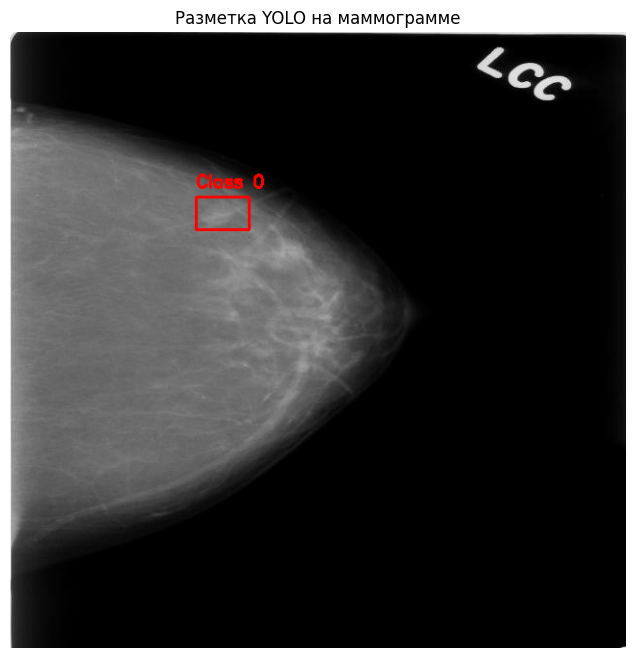

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

# Пути
img_path = "/kaggle/input/cbis-dataset/valid/images/P_00021_LEFT_CC_Original__png.rf.95a459b3dfbd2a9af081c30316b1ed0c.jpg"
label_path = "/kaggle/input/cbis-dataset/valid/labels/P_00021_LEFT_CC_Original__png.rf.95a459b3dfbd2a9af081c30316b1ed0c.txt"

# Загрузка изображения
image = cv2.imread(img_path)
h, w = image.shape[:2]

# Загрузка и парсинг label-файла
with open(label_path, 'r') as f:
    lines = f.readlines()

for line in lines:
    parts = line.strip().split()
    cls_id = int(parts[0])
    x_center, y_center, box_w, box_h = map(float, parts[1:])

    # Преобразование относительных координат в пиксели
    x1 = int((x_center - box_w / 2) * w)
    y1 = int((y_center - box_h / 2) * h)
    x2 = int((x_center + box_w / 2) * w)
    y2 = int((y_center + box_h / 2) * h)

    # Отрисовка рамки
    color = (0, 0, 255)  # Красный
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(image, f"Class {cls_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

# Отображение
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Разметка YOLO на маммограмме")
plt.axis("off")
plt.show()
#[a]

# Grid Cam 

In [7]:
# import os
# import cv2
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# from PIL import Image
# from torchvision import models, transforms

# # === YOLO: преобразование координат ===
# def yolo_to_bbox(yolo_line, img_width, img_height):
#     class_id, cx, cy, w, h = map(float, yolo_line.strip().split())
#     x1 = int((cx - w / 2) * img_width)
#     y1 = int((cy - h / 2) * img_height)
#     x2 = int((cx + w / 2) * img_width)
#     y2 = int((cy + h / 2) * img_height)
#     return int(class_id), x1, y1, x2, y2

# # === Подготовка модели ===
# model = models.efficientnet_b0(pretrained=True)
# model.eval()

# # === Grad-CAM функция ===
# def generate_heatmap(model, image_tensor, target_class):
#     image_tensor = image_tensor.unsqueeze(0)
#     image_tensor.requires_grad_()

#     activations = []
#     gradients = []

#     def forward_hook(module, input, output):
#         activations.append(output)

#     def backward_hook(module, grad_in, grad_out):
#         gradients.append(grad_out[0])

#     # Подключаемся к последнему сверточному слою
#     target_layer = model.features[-1]
#     handle_f = target_layer.register_forward_hook(forward_hook)
#     handle_b = target_layer.register_full_backward_hook(backward_hook)

#     # Forward
#     output = model(image_tensor)
#     model.zero_grad()
#     class_loss = output[0, target_class]
#     class_loss.backward()

#     # Grad-CAM
#     grads = gradients[0].cpu().detach().numpy()[0]
#     fmap = activations[0].cpu().detach().numpy()[0]

#     weights = np.mean(grads, axis=(1, 2))
#     cam = np.sum(weights[:, None, None] * fmap, axis=0)
#     cam = np.maximum(cam, 0)

#     cam = cv2.resize(cam, (image_tensor.shape[2], image_tensor.shape[3]))
#     cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
#     cam = np.uint8(255 * cam)
#     heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

#     handle_f.remove()
#     handle_b.remove()

#     return heatmap

# # === Преобразования ===
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225]
#     ),
# ])

# # === Пути ===
# img_path = "/kaggle/input/cbis-dataset/valid/images/P_00021_LEFT_CC_Original__png.rf.95a459b3dfbd2a9af081c30316b1ed0c.jpg"
# label_path = "/kaggle/input/cbis-dataset/valid/labels/P_00021_LEFT_CC_Original__png.rf.95a459b3dfbd2a9af081c30316b1ed0c.txt"

# # === Подготовка изображения ===
# image_pil = Image.open(img_path).convert("RGB")
# image_tensor = transform(image_pil)
# img_width, img_height = image_pil.size

# # === Предсказание класса ===
# with torch.no_grad():
#     output = model(image_tensor.unsqueeze(0))
#     predicted_class = output.argmax(dim=1).item()

# # === Генерация тепловой карты ===
# heatmap = generate_heatmap(model, image_tensor, predicted_class)

# # === Подготовка фонового изображения (в RGB) ===
# image_np = np.array(image_pil.resize((224, 224)))
# overlay = cv2.addWeighted(image_np, 0.6, heatmap, 0.4, 0)

# # === Отрисовка YOLO рамки ===
# if os.path.exists(label_path):
#     with open(label_path) as f:
#         for line in f:
#             class_id, x1, y1, x2, y2 = yolo_to_bbox(line, 224, 224)
#             overlay = cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)
#             overlay = cv2.putText(overlay, f"Class {class_id}", (x1, y1 - 10),
#                                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# # === Отображение ===
# plt.figure(figsize=(6, 6))
# plt.imshow(overlay)
# plt.title("Grad-CAM + YOLO")
# plt.axis("off")
# plt.show()


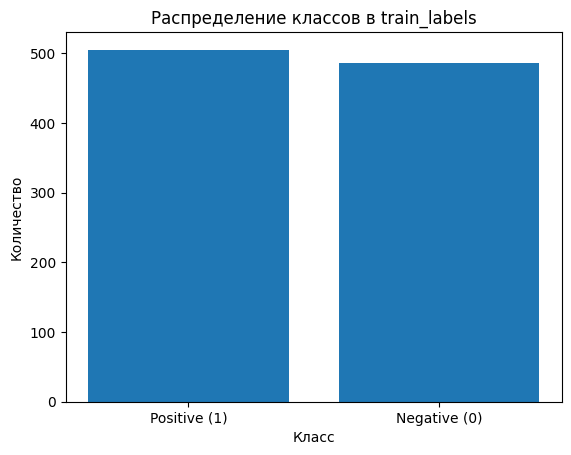

In [8]:
import matplotlib.pyplot as plt

counts = Counter(train_labels.values())
plt.bar(counts.keys(), counts.values(), tick_label=['Negative (0)', 'Positive (1)'])
plt.title("Распределение классов в train_labels")
plt.xlabel("Класс")
plt.ylabel("Количество")
plt.show()


In [9]:
# Добавьте после загрузки меток
def analyze_class_distribution(labels_dict):
    values = list(labels_dict.values())
    unique, counts = np.unique(values, return_counts=True)
    print(f"Распределение классов: {dict(zip(unique, counts))}")
    return dict(zip(unique, counts))

train_dist = analyze_class_distribution(train_labels)
valid_dist = analyze_class_distribution(valid_labels)

Распределение классов: {0: 505, 1: 486}
Распределение классов: {0: 80, 1: 95}


# Breast cancer env

In [10]:


class BreastCancerEnv(gym.Env):
    def __init__(self, features, labels_dict, file_names, episode_length=30, reward_config=None):
        super(BreastCancerEnv, self).__init__()
        self.features = features
        self.labels_dict = labels_dict
        self.file_names = file_names
        self.episode_length = episode_length
        self.reward_config = reward_config or {
            'TP': 1.0,
            'TN': 0.5,
            'FP': -1.0,
            'FN': -2.0
        }

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(features.shape[1],), dtype=np.float32
        )
        self.action_space = spaces.Discrete(2)

        self.current_step = 0
        self.indices = []

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.indices = np.random.choice(len(self.features), self.episode_length, replace=False)
        self.current_step = 0
        idx = self.indices[self.current_step]
        return self.features[idx], {}

    def step(self, action):
        idx = self.indices[self.current_step]
        fname = self.file_names[idx]
        true_label = self.labels_dict.get(fname, 0)

        # Применяем reward_config
        if action == 1 and true_label == 1:
            reward = self.reward_config['TP']
        elif action == 0 and true_label == 0:
            reward = self.reward_config['TN']
        elif action == 1 and true_label == 0:
            reward = self.reward_config['FP']
        elif action == 0 and true_label == 1:
            reward = self.reward_config['FN']
        else:
            reward = -0.1  # fallback, если что-то пойдет не так

        self.current_step += 1
        done = self.current_step >= self.episode_length

        if not done:
            next_obs = self.features[self.indices[self.current_step]]
        else:
            next_obs = np.zeros_like(self.features[0])

        return next_obs, reward, done, False, {}


In [39]:
def evaluate_model_full(model, features, labels_dict, file_names, verbose=True):
    tp = tn = fp = fn = 0
    predictions = []
    truths = []

    for i in range(len(features)):
        state = features[i]
        fname = file_names[i]
        true_label = labels_dict.get(fname, 0)

        action, _ = model.predict(state, deterministic=True)
        action = int(action)

        predictions.append(action)
        truths.append(true_label)

        if action == 1 and true_label == 1:
            tp += 1
        elif action == 0 and true_label == 0:
            tn += 1
        elif action == 1 and true_label == 0:
            fp += 1
        elif action == 0 and true_label == 1:
            fn += 1

    steps = len(predictions)
    accuracy = (tp + tn) / steps if steps > 0 else 0

    if verbose:
        print(f"\n📊 Валидация на всей выборке:")
        print(f"Точность: {accuracy * 100:.2f}%")
        print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

    return accuracy, tp, tn, fp, fn, predictions, truths


In [40]:
%%time
# Создание среды
train_env = lambda: BreastCancerEnv(features, train_labels, file_names, episode_length=100)
valid_env = BreastCancerEnv(valid_features, valid_labels, valid_file_names, episode_length=100)

# Обёртка в make_vec_env
from stable_baselines3.common.env_util import make_vec_env
vec_env = make_vec_env(train_env, n_envs=1)

# Создание модели
model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=1e-4,
    gamma=0.95,
    n_steps=256,
    batch_size=64,
    ent_coef=0.01,
    tensorboard_log="./ppo_logs/"
)

# Обучение с валидацией каждые 10_000 шагов
total_timesteps = 150_000
validation_interval = 1_000
for step in range(0, total_timesteps, validation_interval):
    model.learn(total_timesteps=validation_interval, reset_num_timesteps=False)
    acc, tp, tn, fp, fn, preds, trues = evaluate_model_full(model, valid_env, valid_labels, valid_file_names)

    print(f"\n📊 Валидация на шаге {step + validation_interval}:")
    print(f"Точность: {acc * 100:.2f}%")
    print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")


Using cuda device
Logging to ./ppo_logs/PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -33.8    |
| time/              |          |
|    fps             | 783      |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 256      |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 100           |
|    ep_rew_mean          | -32.4         |
| time/                   |               |
|    fps                  | 613           |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 512           |
| train/                  |               |
|    approx_kl            | 0.00023638667 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        

TypeError: object of type 'BreastCancerEnv' has no len()

In [36]:
# Вызов функции оценки модели
_, _, _, _, _, predictions, truths = evaluate_model(model, valid_env, valid_labels, valid_file_names)



📊 Валидация:
Точность: 47.00%
TP: 0, TN: 47, FP: 53, FN: 0
Precision: 0.00, Recall: 0.00, F1: 0.00


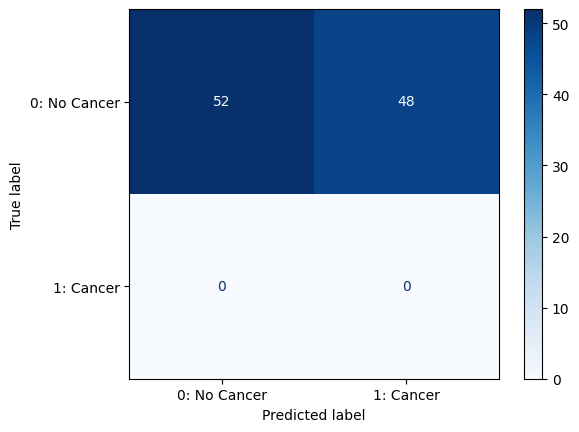

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(truths, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0: No Cancer", "1: Cancer"])
disp.plot(cmap="Blues")


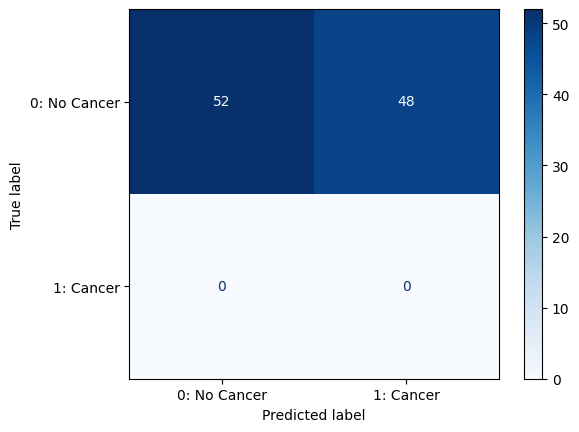

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(truths, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0: No Cancer", "1: Cancer"])
disp.plot(cmap="Blues")


# Validation

In [16]:
valid_data = np.load("/kaggle/input/rl-features/valid_features.npz", allow_pickle=True)
valid_features = valid_data['features']
valid_file_names = valid_data['file_names']
valid_labels = load_yolo_labels("valid/labels", valid_file_names)

valid_env = BreastCancerEnv(valid_features, valid_labels, valid_file_names, episode_length=100)

# Загрузка обученной модели
model = PPO.load("ppo_breast_cancer_trained")

# Тестирование
state, _ = valid_env.reset()
done = False
total_reward = 0
correct = 0
n_steps = 0

while not done:
    action, _ = model.predict(state, deterministic=True)
    state, reward, done, _, _ = valid_env.step(action)
    total_reward += reward
    if reward > 0:
        correct += 1
    n_steps += 1

accuracy = correct / n_steps
print(f"Точность на валидации: {accuracy * 100:.2f}%")


FileNotFoundError: [Errno 2] No such file or directory: 'ppo_breast_cancer_trained.zip'

In [ ]:
state, _ = valid_env.reset()
done = False
correct = 0
n_steps = 0

while not done:
    action, _ = model.predict(state, deterministic=True)
    state, reward, done, _, _ = valid_env.step(action)

    idx = valid_env.indices[valid_env.current_step - 1]
    fname = valid_file_names[idx]
    true_label = valid_labels.get(fname, 0)

    if action == true_label:
        correct += 1

    n_steps += 1

accuracy = correct / n_steps
print(f"Точность на валидации: {accuracy * 100:.2f}%")
